In [2]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import anndata as ad
import muon as mu
import scanpy as sc
import torch
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap # umap-learn

import cellij

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

# random seed to use throughout the notebook
seed = 123


In [4]:
mdata = cellij.core.Importer().load_Guo2010()

model = cellij.core.models.SimpleGP(
    n_factors=2
)

model.add_data(data=mdata)
model.add_covariate(mdata.obs[["division_scaled"]])
model.fit(
    likelihoods="Normal",
    epochs=10000,
    verbose_epochs=1000,
    learning_rate=0.01,
)


Training Model...
- Epoch      0/10000 | Train Loss:           2.33 	


/Users/tim.treis/anaconda3/envs/spatialdata/envs/cellij/lib/python3.9/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'w_qPCR', 'sigma_qPCR'}
  warnings.warn(


- Epoch   1000/10000 | Train Loss:         -16.31 	| Decrease: 800.91%	| Time:  12.96s
- Epoch   2000/10000 | Train Loss:         -25.35 	| Decrease: -55.45%	| Time:  13.05s
- Epoch   3000/10000 | Train Loss:         -31.80 	| Decrease: -25.45%	| Time:  12.67s
- Epoch   4000/10000 | Train Loss:         -36.79 	| Decrease: -15.69%	| Time:  12.75s
- Epoch   5000/10000 | Train Loss:         -40.55 	| Decrease: -10.22%	| Time:  12.66s
- Epoch   6000/10000 | Train Loss:         -45.89 	| Decrease: -13.17%	| Time:  12.68s
- Epoch   7000/10000 | Train Loss:         -44.52 	| Decrease:   2.99%	| Time:  12.90s
- Epoch   8000/10000 | Train Loss:         -46.75 	| Decrease:  -5.01%	| Time:  12.89s
Early stopping of training due to convergence at step 8563
Training finished.
- Final loss: -49.87
- Training took 109.74s


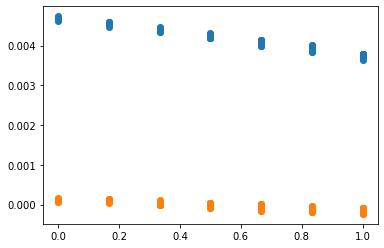

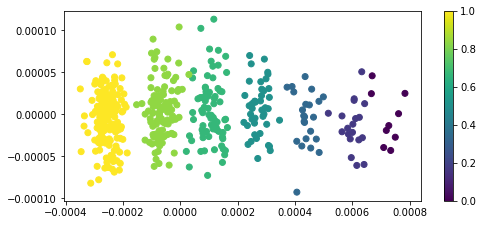

In [6]:
factor_means = []
with torch.no_grad():
    dist = model.gp(model.covariate)
    samples = dist(torch.Size([100000])).cpu()
    mean = samples.mean(dim=0)
    mean = torch.transpose(mean, -1, -2)
    factor_means.append(torch.transpose(mean, -1, -2))

factor_means = torch.stack(factor_means, dim=0)

for i in range(10):
    try:
        plt.scatter(model.covariate.cpu().detach().numpy(), factor_means.squeeze()[i], )
    except:
        pass
    
# umap_obj = umap.UMAP()
# result = umap_obj.fit_transform(factor_means.squeeze().T)

pca = PCA(n_components=2)
result = pca.fit_transform(factor_means.squeeze().T)

result = pd.DataFrame(result)
result["time"] = mdata.obs["division_scaled"].values
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8, 3.5))
s = axs.scatter(result[0], result[1], c = result["time"])
fig.colorbar(s, ax=axs)